In [1]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras import layers, models

import pickle
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_data, train_labels), (test_data, test_labels) = pickle.load( open( "reuters.p", "rb" ) )
print(train_data.shape)
print(np.bincount(train_labels))

(8982,)
[  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
   26   20  444   39   66  549  269  100   15   41   62   92   24   15
   48   19   45   39   32   11   50   10   49   19   19   24   36   30
   13   21   12   18]


In [3]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [5]:
def to_one_hot(labels, dimension = 46):
    one_hot = np.zeros((len(labels), dimension))
    for n, i in enumerate(labels):
        one_hot[n, i] = 1.
    return one_hot

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
print(one_hot_train_labels[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
ohtr = OneHotEncoder().fit_transform(train_labels[:, np.newaxis])
#print(ohtr)
(ohtr.todense() == one_hot_train_labels).all()

/home/levan/scripts/ds_new/venv_ds/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


True

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_train_labels,
                                                  test_size=0.1, stratify = one_hot_train_labels)
print(x_train.shape, x_val.shape)

(8083, 10000) (899, 10000)


In [18]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape = (10000, )))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])

In [19]:
history = model.fit(x_train, y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

Train on 8083 samples, validate on 899 samples
Epoch 1/9
8083/8083 [==============================] - 1s 68us/sample - loss: 2.2153 - acc: 0.5977 - val_loss: 1.4800 - val_acc: 0.7164
Epoch 2/9
8083/8083 [==============================] - 0s 40us/sample - loss: 1.1283 - acc: 0.7757 - val_loss: 1.1460 - val_acc: 0.7642
Epoch 3/9
8083/8083 [==============================] - 0s 38us/sample - loss: 0.7787 - acc: 0.8482 - val_loss: 1.0039 - val_acc: 0.7964
Epoch 4/9
8083/8083 [==============================] - 0s 39us/sample - loss: 0.5728 - acc: 0.8904 - val_loss: 0.9239 - val_acc: 0.8087
Epoch 5/9
8083/8083 [==============================] - 0s 38us/sample - loss: 0.4335 - acc: 0.9141 - val_loss: 0.8896 - val_acc: 0.8109
Epoch 6/9
8083/8083 [==============================] - 0s 41us/sample - loss: 0.3391 - acc: 0.9323 - val_loss: 0.8694 - val_acc: 0.8109
Epoch 7/9
8083/8083 [==============================] - 0s 39us/sample - loss: 0.2702 - acc: 0.9406 - val_loss: 0.8579 - val_acc: 0.8220
E

In [20]:
model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 100us/sample - loss: 0.9179 - acc: 0.7979


[0.9179177114396677, 0.7978629]

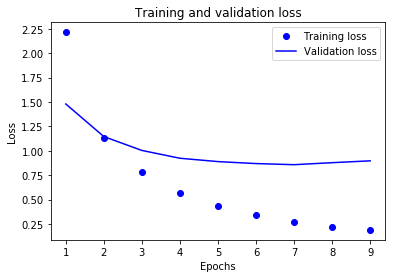

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

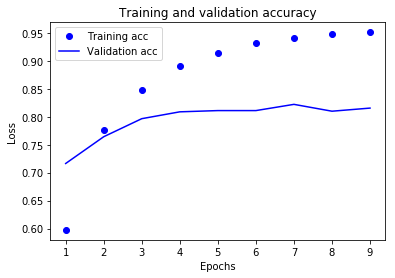

In [22]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])